In [61]:
import essentia
import essentia.standard as ess
import matplotlib.pyplot as plt
import numpy as np


filename = 'audio/vignesh.wav'
fs = 44100

audio = ess.MonoLoader(filename = filename, 
                                          sampleRate = fs)()
# dynamic range expansion as done in HTK implementation
audio = audio*2**15


NUM_BANDS  = 26
DCT_TYPE = 2
LIFTERING = 0
NUM_MFCCs = 13
    
hopSize = 1024 
frameSize = fftSize = 2048
spectrumSize= fftSize//2+1

w = ess.Windowing(type = 'hamming', #  corresponds to htk default  USEHAMMING = T
                        size = fftSize, 
                        normalized = False,
                        zeroPhase = False)
spectrum = ess.Spectrum(size = fftSize)


In [10]:
mfcc_slaney = ess.MFCC(inputSize = spectrumSize,
                    highFrequencyBound = 8000,
                    numberBands = 26,
                    numberCoefficients = 13)

mfcc_htk = ess.MFCC(inputSize = spectrumSize,
                        type = 'magnitude', # htk uses mel filterbank magniude
                        warpingFormula = 'htkMel', # htk's mel warping formula
                        weighting = 'linear', # computation of filter weights done in Hz domain
                        highFrequencyBound = 8000, # corresponds to htk default
                        lowFrequencyBound = 0, # corresponds to htk default
                        numberBands = NUM_BANDS, # corresponds to htk default  NUMCHANS = 26
                        numberCoefficients = 13,
                        normalize = 'unit_max', # htk filter normaliation to have constant height = 1  
                        dctType = 3, # htk uses DCT type III
                        logType = 'log',
                        liftering = 22) # corresponds to htk default CEPLIFTER = 22

In [59]:


mel_bands_slaney = []
mfccs_slaney = []

mel_bands_htk = []
mfccs_htk = []

    # startFromZero = True, validFrameThresholdRatio = 1 : the way htk computes windows
for frame in ess.FrameGenerator(audio, frameSize = frameSize, hopSize = hopSize):
        
       
        spect = spectrum(w(frame))

        mel_bands, mfcc_coeffs = mfcc_slaney(spect)
        mel_bands_slaney.append(mel_bands)
        mfccs_slaney.append(mfcc_coeffs)
        
        mel_bands, mfcc_coeffs = mfcc_htk(spect)
        mel_bands_htk.append(mel_bands)
        mfccs_htk.append(mfcc_coeffs)


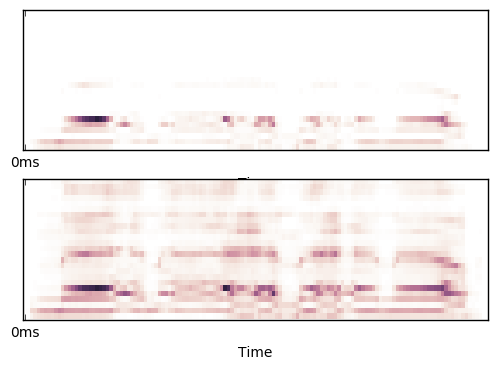

In [28]:
#### plot mel bands

import librosa 

mel_bands = essentia.array(mel_bands_slaney).T
plt.subplot(2, 1, 1)
librosa.display.specshow(mel_bands, sr=44100, hop_length=hopSize, x_axis='time')

mel_bands = essentia.array(mel_bands_htk).T
plt.subplot(2, 1, 2)
librosa.display.specshow(mel_bands, sr=44100, hop_length=hopSize, x_axis='time')

plt.show() 
    

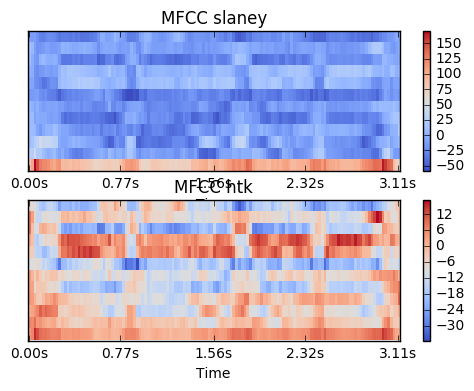

In [30]:
#### plot mfccs

import librosa 

mfccs = essentia.array(mfccs_slaney).T
plt.subplot(2, 1, 1)
librosa.display.specshow(mfccs[1:,:], sr=44100, hop_length=hopSize, x_axis='time')
plt.colorbar()
plt.title('MFCC slaney')

mfccs = essentia.array(mfccs_htk).T
plt.subplot(2, 1, 2)
librosa.display.specshow(mfccs[1:,:], sr=44100, hop_length=hopSize, x_axis='time')
plt.colorbar()
plt.title('MFCC htk')

plt.show() 


In [58]:
#### comparison inverse MFCC
#### taken from https://github.com/MTG/essentia/blob/master/src/examples/tutorial/example_inverse_mfccs.py
idct = ess.IDCT(inputSize=NUM_MFCCs, 
                outputSize=NUM_BANDS, 
                dctType = 3, 
                liftering = 22)


all_melbands_smoothed = []
for frame in ess.FrameGenerator(audio, frameSize = frameSize, hopSize = hopSize):
		spect = spectrum(w(frame))
		melbands, mfcc_coeffs = mfcc_htk(spect)
		melbands_smoothed = np.exp(idct(mfcc_coeffs[:])) # inverse the log taken in MFCC computation
		all_melbands_smoothed.append(melbands_smoothed)

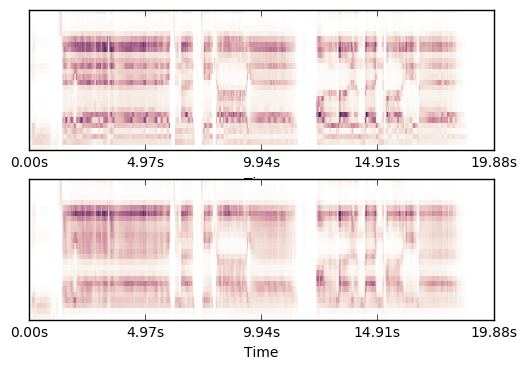

In [60]:
#### plot mel bands and inverted smoothed mel bands

import librosa 

mel_bands = essentia.array(mel_bands_htk).T
plt.subplot(2, 1, 1)
librosa.display.specshow(mel_bands, sr=44100, hop_length=hopSize, x_axis='time')


mel_bands = essentia.array(all_melbands_smoothed).T
plt.subplot(2, 1, 2)
librosa.display.specshow(mel_bands, sr=44100, hop_length=hopSize, x_axis='time')

plt.show() 